**Experiment 1**: use linear transformation matrix to weight collocates.
See http://www.dialog-21.ru/media/3908/enikeevaevmitrofanovaoa.pdf

In [2]:
from gensim.models.word2vec import KeyedVectors

In [3]:
import numpy as np

In [4]:
from sklearn.cross_validation import train_test_split

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

## Utility functions

In [6]:
def train_test_split_(coll_data, test_word=None, b_pos='_S', c_pos='_V'):
    B = []
    C = []
    collset = []
    target_b_vec, target_c_vec, target_coll = [], [], []
    for x in coll_data:
        b_vec, c_vec = 0, 0
        if test_word:
            if x[0] == test_word:
                try:
                    target_c_vec.append(c_model[x[1].split('_')[0]])
                    target_b_vec.append(b_model[x[0].split('_')[0] + b_pos])
                    target_coll.append(x)
                except:
                    pass
                continue
            continue
        try:
            b_vec = b_model[x[0].split('_')[0] + b_pos]
            c_vec = c_model[x[1].split('_')[0]]
        except KeyError:
            pass
        if type(b_vec) != int and type(c_vec) != int:
            collset.append(x)
            B.append(b_vec)
            C.append(c_vec)
    if test_word:
        return np.array(B), target_m_vec, collset, target_coll, np.array(C), target_c_vec

    return train_test_split(np.array(B), collset, np.array(C))

## Load models and precompute weights

In [7]:
pm_corr = {
    '_V': "INFN",
    '_S': "NOUN",
    '_A': "ADJF",
    '_ADV': "ADVB"
}

In [8]:
def most_similar_baseline(self, pos_w, neg_w, topn=5, pos='_V', use_pm=False):
    best = self.most_similar_cosmul(pos_w, neg_w, topn=topn*5)
    if use_pm:
        return list(filter(lambda x: filter_pm_pos(x[0], pos), best))[:topn]
    return list(filter(lambda x: x[0].endswith(pos), best))[:topn]

In [9]:
def filter_pm_pos(word, pos):
    parses = morph.parse(word)
    if pos in ('_A', '_S'):
        return pm_corr[pos] in [p.tag.POS for p in parses] \
            and np.all(['Apro' not in p.tag for p in parses])
    return pm_corr[pos] in [p.tag.POS for p in morph.parse(word)]

In [10]:
def most_similar_by_wv(self, vectenter, topn=5, pos='_V', use_pm=False):
    best = self.similar_by_vector(vectenter, topn=topn*5)
    if use_pm:
        return list(filter(lambda x: filter_pm_pos(x[0], pos), best))[:topn]
    return list(filter(lambda x: x[0].endswith(pos), best))[:topn]

In [11]:
def most_similar_vector(self, vectenter, topn=5, pos='_V', use_pm=False):
    self.init_sims()
    dists = np.dot(self.syn0norm, vectenter)
    if not topn:
        return dists
    best = np.argsort(dists)[::-1][:topn*5]
        # ignore (don't return) words from the input
    result = [(self.index2word[sim], float(dists[sim])) for sim in best]
    if use_pm:
        return list(filter(lambda x: filter_pm_pos(x[0], pos), result))[:topn]
    return list(filter(lambda x: x[0].endswith(pos), result))[:topn]

In [14]:
b_model = KeyedVectors.load_word2vec_format('../data/ruscorpora.model.bin', binary=True)

In [15]:
c_model = KeyedVectors.load_word2vec_format('../data/wiki-ru.vec.bin', binary=True)

In [16]:
c_model.init_sims(replace=True)

## Load train/test data

In [35]:
def load_links(lf='attr', b_pos='_S', c_pos='_A'):
    coll_ = []
    with open('../../data/synt_links_%s' % lf, 'r') as f:
        for line in f:
            line = line.rstrip('\r\n').split('\t')
            if pm_corr[c_pos] in [x.tag.POS for x in morph.parse(line[0])] \
            and pm_corr[b_pos] in [x.tag.POS for x in morph.parse(line[1])]:
                pair = (line[1].lower() + b_pos, line[0].lower() + c_pos)
                if not pair in coll_:
                    coll_.append(pair)
    return coll_

In [28]:
def load_syntagrus_lf(lf='_OPER1', b_pos='_S', c_pos='_V'):
    coll_lf = []
    with open('../../data/lf.SynTagRus.tsv', 'r') as f:
        for line in f:
            line = line.rstrip('\r\n').split('\t')
            if line[0] == lf:
                pair = (line[1].lower() + b_pos, line[2].lower() + c_pos)
                if not pair in coll_lf:
                    coll_lf.append(pair)
    return coll_lf

In [29]:
def load_fuzzy_syntagrus_lf(lf='_OPER', b_pos='_S', c_pos='_V'):
    coll_lf = []
    with open('../../data/lf.SynTagRus.tsv', 'r') as f:
        for line in f:
            line = line.rstrip('\r\n').split('\t')
            if lf in line[0]:
                pair = (line[1].lower() + b_pos, line[2].lower() + c_pos)
                if not pair in coll_lf:
                    coll_lf.append(pair)
    return coll_lf

In [30]:
def load_pair_to_lf(coll_lf, lf='_OPER', b_pos='_S', c_pos='_V'):
    with open('../../data/lf.SynTagRus.tsv', 'r') as f:
        for line in f:
            line = line.rstrip('\r\n').split('\t')
            if lf in line[0]:
                pair = (line[1].lower() + b_pos, line[2].lower() + c_pos)
                if not pair in coll_lf:
                    coll_lf[pair] = line[0]

## linear transformation

In [21]:
def lintransform(M_train, C_train):
    return np.linalg.pinv(M_train).dot(C_train).T

## Load verbal collocations

In [19]:
import re
op = re.compile(u'.*order=(?P<order>[NV]+)')
coll_ = []
with open('data/lf.verb_coll', 'r') as f:
    for line in f:
        line = line.rstrip('\r\n').split('\t')
        if 'base=действие' in line[1].split() and 'mood=субъект' in line[1].split():
            m_p = op.search(line[1])
            if m_p.group('order'):
                i = m_p.group('order').index('V')
                try:
                    collocate = line[2].split()[i]
                    pair = (line[0], morph.parse(collocate)[0].normal_form)
                    if not pair in coll_:
                        coll_.append(pair)
                except IndexError:
                    pass

In [22]:
B_train, B_test, coll_train, coll_test, C_train, C_test = train_test_split_(coll_)

## Load LF examples

Use LF arguments as base words and LF values as collocates. Score pairs from testset and find most probable LF values.

In [31]:
coll_1 = load_fuzzy_syntagrus_lf("FUNC", c_pos="_V", b_pos="_S")
coll_2 = load_fuzzy_syntagrus_lf("OPER", c_pos="_V", b_pos="_S")
coll_lf = coll_1 + coll_2
B_train, B_test, coll_train, coll_test, C_train, C_test = train_test_split_(coll_lf, b_pos="_S", c_pos="")
X = lintransform(B_train, C_train)

In [48]:
for i, test_vec in enumerate(B_test):
    trans_vec = X.dot(test_vec.T)
#     trans_vec1 = Y.dot(M_test[i].T)
    base, target_coll = coll_test[i]
    res = np.array([x for x in most_similar_by_wv(c_model, trans_vec, topn=100, pos="_V", use_pm=True)])
    j, = np.where(res[:, 0] == target_coll.split('_')[0])
    if len(j):
        print(base, target_coll, j[0])
        for w in res[:10]:
            print('\t%s\t%.4f' % (w[0], float(w[1])))
    if target_coll + '' in res:
        true_ans1 += 1

боль_S вызывать_V 64
	испытывать	0.7445
	ощущать	0.6744
	чувствовать	0.6641
	почувствовать	0.6581
	мучить	0.6448
	забеспокоиться	0.6333
	мучаться	0.6325
	возникать	0.6265
	терзать	0.6256
	обуревать	0.6242
отбор_S вести_V 8
	проходить	0.7850
	идти	0.6500
	проводиться	0.6242
	проводить	0.6033
	происходить	0.5847
	начинаться	0.5613
	осуществляться	0.5449
	производить	0.5078
	вести	0.5029
	производиться	0.5028
название_S получать_V 1
	давать	0.8182
	получать	0.6525
	иметь	0.6415
	носить	0.6403
	называть	0.5939
	давнуть	0.5715
	использовать	0.5158
	хотеть	0.5123
	существовать	0.4991
	даваться	0.4937
альпиниада_S состояться_V 3
	проводить	0.7780
	проходить	0.5927
	проводиться	0.5580
	состояться	0.5554
	проводеть	0.5351
	отыгрывать	0.5150
	устраивать	0.5134
	состяться	0.5040
	простудившиться	0.4965
	питтодрить	0.4764
контракт_S расторгать_V 3
	подписывать	0.7740
	заключать	0.7143
	подписать	0.7019
	расторгать	0.6240
	расторгнуть	0.6141
	перезаключить	0.6099
	подписасть	0.5978
	переподписывать

крюк_S делать_V 0
	делать	0.5844
	рубиться	0.5681
	слоняться	0.5637
	заматывать	0.5568
	нянчиться	0.5485
	развлекаться	0.5457
	размахиваться	0.5454
	попрошайничать	0.5449
	караулить	0.5427
	протрезветь	0.5410
задержание_S производить_V 16
	принимать	0.5789
	инициировать	0.5636
	проводить	0.5506
	вызывать	0.5465
	осуществлять	0.5414
	подвергать	0.5302
	подвергаться	0.5198
	участвовать	0.5183
	совершать	0.5089
	провестись	0.5075
матч_S состояться_V 4
	проводить	0.8656
	проводиться	0.6716
	проходить	0.6529
	провесть	0.6443
	состояться	0.6094
	проводеть	0.6051
	организовывать	0.5878
	провестись	0.5648
	устраивать	0.5545
	состяться	0.5379
ревизия_S подвергаться_V 35
	проводить	0.8026
	проходить	0.7383
	проводиться	0.6899
	состояться	0.6407
	провесть	0.6259
	организовывать	0.5979
	устраивать	0.5845
	проводеть	0.5475
	осуществлять	0.5390
	провестись	0.5382
эмиграция_S возвращаться_V 58
	делать	0.6003
	сделать	0.5376
	производить	0.5104
	совершать	0.5064
	кувеходить	0.5044
	штормить	0.4967
	ув

KeyboardInterrupt: 

## Revert relations

Use LF values as base words and LF arguments as collocates to be detected.
Join FUNC and OPER groups of LFs and learn transformation from verbs to their arguments.

In [32]:
C_train_rev, C_test_rev, coll_train_rev, coll_test_rev, B_train_rev, B_test_rev = train_test_split_(coll_lf, b_pos="_S", c_pos="")
X = lintransform(B_train_rev, C_train_rev)

In [33]:
# load mapping: (c, b) -> LF name
pair_to_lf = {}
load_pair_to_lf(pair_to_lf, "FUNC", c_pos="_V", b_pos="_S")
load_pair_to_lf(pair_to_lf, "OPER", c_pos="_V", b_pos="_S")

In [113]:
# Score top-100 LF arguments
outf = open("data/lf_top100.res", "w")
for i, test_vec in enumerate(B_test_rev):
    trans_vec = X.dot(test_vec.T)
    target_coll, base = coll_test_rev[i]
    lf = pair_to_lf[(target_coll, base)]
    if lf.startswith("_S0"): # nominalization LFs
        continue
    res = np.array([x for x in most_similar_by_wv(b_model, trans_vec, topn=500, pos="_S")])
    j, = np.where(res[:, 0] == target_coll)
    if len(j):
        for w in res[:100]:
            print('%s\t%s\t%s\t%.4f' % (lf, base, w[0], float(w[1])), file=outf)
outf.close()

----

In [36]:
verb_coll = load_links('obj', '_V', '_S')

In [38]:
import random
test_verb_coll = random.sample(verb_coll, 500)

In [95]:
test_verb_coll

[('определять_V', 'часть_S'),
 ('отстаивать_V', 'свобода_S'),
 ('давать_V', 'концерт_S'),
 ('читать_V', 'душа_S'),
 ('посвящать_V', 'я_S'),
 ('загрязнять_V', 'среда_S'),
 ('пересматривать_V', 'прогноз_S'),
 ('отдавать_V', 'команда_S'),
 ('оперировать_V', 'капитал_S'),
 ('напоминать_V', 'торт_S'),
 ('обретать_V', 'дыхание_S'),
 ('оценивать_V', 'вклад_S'),
 ('добавлять_V', 'предмет_S'),
 ('признавать_V', 'миллиард_S'),
 ('следовать_V', 'союз_S'),
 ('собирать_V', 'информация_S'),
 ('порождать_V', 'маска_S'),
 ('интерпретировать_V', 'оценка_S'),
 ('преподавать_V', 'живопись_S'),
 ('проверять_V', 'курганстальмост_S'),
 ('дожидаться_V', 'презентация_S'),
 ('продавать_V', 'боеприпас_S'),
 ('оберегать_V', 'рукопись_S'),
 ('беречь_V', 'культура_S'),
 ('предписывать_V', 'эвакуация_S'),
 ('отражать_V', 'состояние_S'),
 ('нести_V', 'благо_S'),
 ('доначислять_V', 'ндс_S'),
 ('чувствовать_V', 'содрогание_S'),
 ('приводить_V', 'выдержка_S'),
 ('способствовать_V', 'карьера_S'),
 ('образовывать_V', 'фе

In [103]:
pos_result = []
for v, s in test_verb_coll:
    try:
        test_vec = c_model[v.split('_')[0]]
        s_vec = b_model[s]
    except KeyError:
        continue
    trans_vec = X.dot(test_vec.T)
    trans_vec /= np.sqrt(np.sum(trans_vec ** 2))
    res = np.array([x for x in most_similar_by_wv(b_model, trans_vec, topn=1000, pos="_S")])
    j, = np.where(res[:, 0] == s)
    if len(j):
        pos_result.append((v, s, j[0], float(res[j][0][1])))
    else:
        pos_result.append((v, s, -1, np.dot(trans_vec, s_vec)))

In [60]:
pos_result = np.array(pos_result)

In [105]:
sorted(pos_result, key=lambda x: x[-1])

[('воспринимать_V', 'прогноз_S', -1, -0.27171829),
 ('удивлять_V', 'семья_S', -1, -0.14197136),
 ('переменять_V', 'пол_S', -1, -0.13153285),
 ('добавлять_V', 'предмет_S', -1, -0.10520752),
 ('проверять_V', 'поляк_S', -1, -0.099192858),
 ('зачитывать_V', 'журнал_S', -1, -0.089535043),
 ('предусматривать_V', 'развитие_S', -1, -0.084269077),
 ('воспрянуть_V', 'дух_S', -1, -0.083287127),
 ('держать_V', 'мать_S', -1, -0.082757786),
 ('видеть_V', 'деятельность_S', -1, -0.082607947),
 ('использовать_V', 'ветер_S', -1, -0.081565671),
 ('связывать_V', 'совершенствование_S', -1, -0.081140019),
 ('отключать_V', 'поселок_S', -1, -0.079726487),
 ('разъяснять_V', 'достоинство_S', -1, -0.079639144),
 ('видеть_V', 'вдова_S', -1, -0.077997573),
 ('кормить_V', 'человек_S', -1, -0.077599786),
 ('приходиться_V', 'игорь_S', -1, -0.075190723),
 ('беспокоить_V', 'житель_S', -1, -0.073953569),
 ('исследовать_V', 'поведение_S', -1, -0.07352253),
 ('выглядеть_V', 'шахта_S', -1, -0.071131304),
 ('удаваться_V', '

In [65]:
test_neg_coll = []
test_neg_verbs = random.sample(verb_coll, 1000)
test_pos_verbs = set([x[0] for x in test_verb_coll])
test_nouns = list(set([x[1] for x in verb_coll]))
random.shuffle(test_nouns)
for v, _ in test_neg_verbs:
    if v not in test_pos_verbs:
        for n in test_nouns:
            if (v, n) not in verb_coll:
                test_neg_coll.append((v, n))
                test_nouns.remove(n)
                break

In [106]:
neg_result = []
for v, s in test_neg_coll:
    try:
        test_vec = c_model[v.split('_')[0]]
        s_vec = b_model[s]
    except KeyError:
        continue
    trans_vec = X.dot(test_vec.T)
    trans_vec /= np.sqrt(np.sum(trans_vec ** 2))
    neg_result.append((v, s, -1, np.dot(trans_vec, s_vec)))

In [107]:
sorted(neg_result, key=lambda x: x[-1])

[('облегчать_V', 'эмансипация_S', -1, -0.21538094),
 ('сбивать_V', 'группка_S', -1, -0.18677354),
 ('подбирать_V', 'разорение_S', -1, -0.17728542),
 ('прикрывать_V', 'бэтман_S', -1, -0.1696056),
 ('обозначать_V', 'известность_S', -1, -0.16290572),
 ('помнить_V', 'похищение_S', -1, -0.12913351),
 ('игнорировать_V', 'осень_S', -1, -0.12808999),
 ('хвастаться_V', 'телемарк_S', -1, -0.11751535),
 ('заставлять_V', 'триггер_S', -1, -0.11561511),
 ('скатывать_V', 'лейкемия_S', -1, -0.1142085),
 ('гарантировать_V', 'предприниматель_S', -1, -0.11230642),
 ('подбирать_V', 'время_S', -1, -0.10731198),
 ('подменять_V', 'клин_S', -1, -0.10366813),
 ('командировать_V', 'галка_S', -1, -0.099184252),
 ('вспоминать_V', 'шуба_S', -1, -0.09853778),
 ('упрощать_V', 'класс_S', -1, -0.097605281),
 ('ремонтировать_V', 'нажим_S', -1, -0.096056223),
 ('снижать_V', 'русич_S', -1, -0.0950801),
 ('распродавать_V', 'препятствие_S', -1, -0.093319342),
 ('трактовать_V', 'гипс_S', -1, -0.093249664),
 ('употреблять_V'

In [71]:
neg_result = np.array(neg_result)

In [83]:
# Positive statistics
pos_scores = np.array(pos_result[:, 3], dtype=float)
print('Mean =', pos_scores.mean())
print('Max = %.6f; Min = %.6f' % (pos_scores.max(), pos_scores.min()))
print('Stdev =', pos_scores.std())

Mean = 0.114501693574
Max = 0.841491; Min = -0.271718
Stdev = 0.145024267939


In [84]:
# Negative statistics
neg_scores = np.array(neg_result[:, 3], dtype=float)
print('Mean =', neg_scores.mean())
print('Max = %.6f; Min = %.6f' % (neg_scores.max(), neg_scores.min()))
print('Stdev =', neg_scores.std())

Mean = 0.032513924432
Max = 0.303586; Min = -0.215381
Stdev = 0.0765697555102


In [92]:
def hist_args(scores):
    heights, bins = np.histogram(scores)
    heights = heights / float(sum(heights))
    binMids = bins[:-1] + np.diff(bins) / 2.
    return binMids, heights

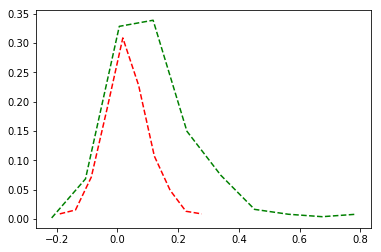

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(*hist_args(neg_scores), 'r--')
plt.plot(*hist_args(pos_scores), 'g--')
plt.show()